In [1]:
%pip install -q "openvino-dev>=2023.1.0"  onnx

Note: you may need to restart the kernel to use updated packages.


In [2]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import openvino as ov
from IPython.display import Markdown, display
from PIL import Image

# Fetch `notebook_utils` module
import urllib.request
urllib.request.urlretrieve(
    url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/notebook_utils.py',
    filename='notebook_utils.py'
)
from notebook_utils import load_image

In [3]:
core = ov.Core()

model_dir = Path("../../python_backend/trained_models/charater_recognition/")
precision = "FP16"
detection_model = "horizontal-text-detection-0001"
recognition_model = "text-recognition-resnet-fc"

model_dir.mkdir(exist_ok=True)

In [4]:
download_command = f"omz_downloader --name {detection_model},{recognition_model} --output_dir {model_dir} --cache_dir {model_dir} --precision {precision}  --num_attempts 5"
display(Markdown(f"Download command: `{download_command}`"))
display(Markdown(f"Downloading {detection_model}, {recognition_model}..."))
!$download_command
display(Markdown(f"Finished downloading {detection_model}, {recognition_model}."))

detection_model_path = (model_dir  / detection_model).with_suffix(".xml")
recognition_model_path = (model_dir/ recognition_model).with_suffix(".xml")

Download command: `omz_downloader --name horizontal-text-detection-0001,text-recognition-resnet-fc --output_dir ../../python_backend/trained_models/charater_recognition --cache_dir ../../python_backend/trained_models/charater_recognition --precision FP16  --num_attempts 5`

Downloading horizontal-text-detection-0001, text-recognition-resnet-fc...

################|| Downloading horizontal-text-detection-0001 ||################

========== Downloading ../../python_backend/trained_models/charater_recognition/intel/horizontal-text-detection-0001/FP16/horizontal-text-detection-0001.xml
... 100%, 815 KB, 553 KB/s, 1 seconds passed

========== Downloading ../../python_backend/trained_models/charater_recognition/intel/horizontal-text-detection-0001/FP16/horizontal-text-detection-0001.bin
... 100%, 3786 KB, 1111 KB/s, 3 seconds passed

################|| Downloading text-recognition-resnet-fc ||################

========== Downloading ../../python_backend/trained_models/charater_recognition/public/text-recognition-resnet-fc/vedastr/models/__init__.py
... 100%, 0 KB, 1010 KB/s, 0 seconds passed

========== Downloading ../../python_backend/trained_models/charater_recognition/public/text-recognition-resnet-fc/vedastr/models/builder.py
... 100%, 0 KB, 1595 KB/s, 0 seconds passed

========== Downloading ../../python_backend/trained_models/ch

Finished downloading horizontal-text-detection-0001, text-recognition-resnet-fc.

In [5]:
convert_command = f"omz_converter --name {recognition_model} --precisions {precision} --download_dir {model_dir} --output_dir {model_dir}"
display(Markdown(f"Convert command: `{convert_command}`"))
display(Markdown(f"Converting {recognition_model}..."))
! $convert_command

Convert command: `omz_converter --name text-recognition-resnet-fc --precisions FP16 --download_dir ../../python_backend/trained_models/charater_recognition --output_dir ../../python_backend/trained_models/charater_recognition`

Converting text-recognition-resnet-fc...

========== Converting text-recognition-resnet-fc to ONNX
Conversion to ONNX command: /bin/python3 -- /home/mktetts/.local/lib/python3.10/site-packages/openvino/model_zoo/internal_scripts/pytorch_to_onnx.py --model-path=/home/mktetts/.local/lib/python3.10/site-packages/openvino/model_zoo/models/public/text-recognition-resnet-fc --model-path=../../python_backend/trained_models/charater_recognition/public/text-recognition-resnet-fc --model-name=get_model --import-module=model '--model-param=file_config=r"../../python_backend/trained_models/charater_recognition/public/text-recognition-resnet-fc/vedastr/configs/resnet_fc.py"' '--model-param=weights=r"../../python_backend/trained_models/charater_recognition/public/text-recognition-resnet-fc/vedastr/ckpt/resnet_fc.pth"' --input-shape=1,1,32,100 --input-names=input --output-names=output --output-file=../../python_backend/trained_models/charater_recognition/public/text-recognition-resnet-fc/resnet_fc.onnx

ONNX check passed successfully.

=====

In [6]:
import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [7]:
print(detection_model_path)
detection_model = core.read_model(
    model=detection_model_path, weights=detection_model_path.with_suffix(".bin")
)
detection_compiled_model = core.compile_model(model=detection_model, device_name=device.value)

detection_input_layer = detection_compiled_model.input(0)

../../python_backend/trained_models/charater_recognition/horizontal-text-detection-0001.xml


RuntimeError: Exception from src/inference/src/core.cpp:100:
[ NETWORK_NOT_READ ] Unable to read the model: ../../python_backend/trained_models/charater_recognition/horizontal-text-detection-0001.xml Please check that model format: xml is supported and the model is correct. Available frontends: onnx ir pytorch tflite tf paddle 


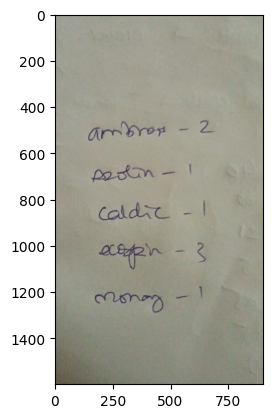

In [ ]:
image_file = "/mnt/hdd/projects/codeshift/sample/sample_prescription.jpeg"
image = load_image(image_file)

# N,C,H,W = batch size, number of channels, height, width.
N, C, H, W = detection_input_layer.shape

# Resize the image to meet network expected input sizes.
resized_image = cv2.resize(image, (W, H))

# Reshape to the network input shape.
input_image = np.expand_dims(resized_image.transpose(2, 0, 1), 0)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));

In [ ]:
output_key = detection_compiled_model.output("boxes")
boxes = detection_compiled_model([input_image])[output_key]

# Remove zero only boxes.
boxes = boxes[~np.all(boxes == 0, axis=1)]

In [ ]:
def multiply_by_ratio(ratio_x, ratio_y, box):
    return [
        max(shape * ratio_y, 10) if idx % 2 else shape * ratio_x
        for idx, shape in enumerate(box[:-1])
    ]


def run_preprocesing_on_crop(crop, net_shape):
    temp_img = cv2.resize(crop, net_shape)
    temp_img = temp_img.reshape((1,) * 2 + temp_img.shape)
    return temp_img


def convert_result_to_image(bgr_image, resized_image, boxes, threshold=0.3, conf_labels=True):
    # Define colors for boxes and descriptions.
    colors = {"red": (255, 0, 0), "green": (0, 255, 0), "white": (255, 255, 255)}

    # Fetch image shapes to calculate a ratio.
    (real_y, real_x), (resized_y, resized_x) = image.shape[:2], resized_image.shape[:2]
    ratio_x, ratio_y = real_x / resized_x, real_y / resized_y

    # Convert the base image from BGR to RGB format.
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

    # Iterate through non-zero boxes.
    for box, annotation in boxes:
        # Pick a confidence factor from the last place in an array.
        conf = box[-1]
        if conf > threshold:
            # Convert float to int and multiply position of each box by x and y ratio.
            (x_min, y_min, x_max, y_max) = map(int, multiply_by_ratio(ratio_x, ratio_y, box))

            # Draw a box based on the position. Parameters in the `rectangle` function are: image, start_point, end_point, color, thickness.
            cv2.rectangle(rgb_image, (x_min, y_min), (x_max, y_max), colors["green"], 3)

            # Add a text to an image based on the position and confidence. Parameters in the `putText` function are: image, text, bottomleft_corner_textfield, font, font_scale, color, thickness, line_type
            if conf_labels:
                # Create a background box based on annotation length.
                (text_w, text_h), _ = cv2.getTextSize(
                    f"{annotation}", cv2.FONT_HERSHEY_TRIPLEX, 0.8, 1
                )
                image_copy = rgb_image.copy()
                cv2.rectangle(
                    image_copy,
                    (x_min, y_min - text_h - 10),
                    (x_min + text_w, y_min - 10),
                    colors["white"],
                    -1,
                )
                # Add weighted image copy with white boxes under a text.
                cv2.addWeighted(image_copy, 0.4, rgb_image, 0.6, 0, rgb_image)
                cv2.putText(
                    rgb_image,
                    f"{annotation}",
                    (x_min, y_min - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.8,
                    colors["red"],
                    1,
                    cv2.LINE_AA,
                )

    return rgb_image

In [ ]:
recognition_model = core.read_model(
    model=recognition_model_path, weights=recognition_model_path.with_suffix(".bin")
)

recognition_compiled_model = core.compile_model(model=recognition_model, device_name=device.value)

recognition_output_layer = recognition_compiled_model.output(0)
recognition_input_layer = recognition_compiled_model.input(0)

# Get the height and width of the input layer.
_, _, H, W = recognition_input_layer.shape

In [ ]:
# Calculate scale for image resizing.
(real_y, real_x), (resized_y, resized_x) = image.shape[:2], resized_image.shape[:2]
ratio_x, ratio_y = real_x / resized_x, real_y / resized_y

# Convert the image to grayscale for the text recognition model.
grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Get a dictionary to encode output, based on the model documentation.
letters = "~0123456789abcdefghijklmnopqrstuvwxyz"

# Prepare an empty list for annotations.
annotations = list()
cropped_images = list()
# fig, ax = plt.subplots(len(boxes), 1, figsize=(5,15), sharex=True, sharey=True)
# Get annotations for each crop, based on boxes given by the detection model.
for i, crop in enumerate(boxes):
    # Get coordinates on corners of a crop.
    (x_min, y_min, x_max, y_max) = map(int, multiply_by_ratio(ratio_x, ratio_y, crop))
    image_crop = run_preprocesing_on_crop(grayscale_image[y_min:y_max, x_min:x_max], (W, H))

    # Run inference with the recognition model.
    result = recognition_compiled_model([image_crop])[recognition_output_layer]

    # Squeeze the output to remove unnecessary dimension.
    recognition_results_test = np.squeeze(result)

    # Read an annotation based on probabilities from the output layer.
    annotation = list()
    for letter in recognition_results_test:
        parsed_letter = letters[letter.argmax()]

        # Returning 0 index from `argmax` signalizes an end of a string.
        if parsed_letter == letters[0]:
            break
        annotation.append(parsed_letter)
    annotations.append("".join(annotation))
    cropped_image = Image.fromarray(image[y_min:y_max, x_min:x_max])
    cropped_images.append(cropped_image)

boxes_with_annotations = list(zip(boxes, annotations))

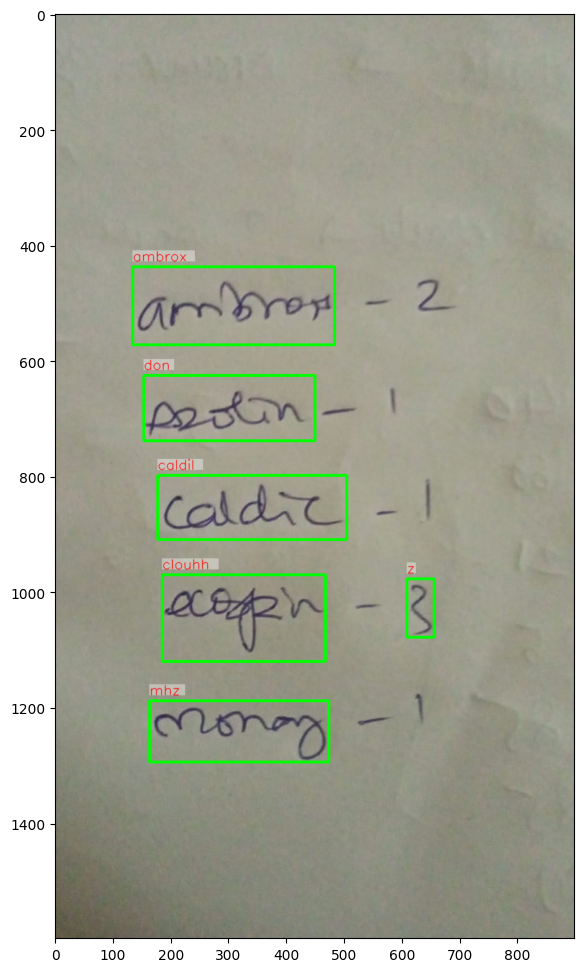

In [ ]:
plt.figure(figsize=(12, 12))
plt.imshow(convert_result_to_image(image, resized_image, boxes_with_annotations, conf_labels=True))

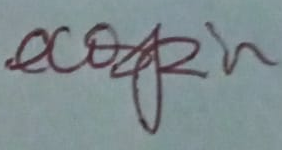

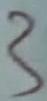

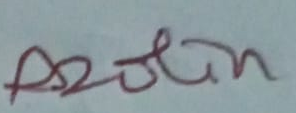

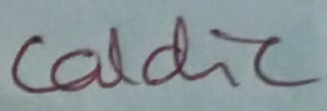

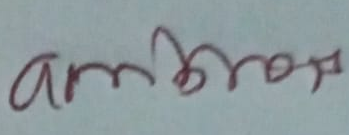

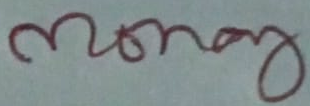

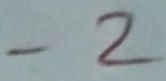

In [ ]:
for cropped_image, annotation in zip(cropped_images, annotations):
    display(cropped_image)

In [ ]:
[
    annotation
    for _, annotation in sorted(zip(boxes, annotations), key=lambda x: x[0][0] ** 2 + x[0][1] ** 2)
]

['ambrox', 'don', 'caldil', 'clouhh', '12', 'mhz', 'z']